# 1. Поиск и подготовка данных.

## Введение.

Для задачи мульти-лейбл классификации был выбран набор данных [$Apparel~images$](https://www.kaggle.com/datasets/trolukovich/apparel-images-dataset), который содержит $11~385$ изображений различной одежды:



*   $black~dress: 450$
*   $black~pants: 871$
*   $black~shirt: 715$
*   $black~shoes: 766$
*   $black~shorts: 328$
*   $blue~dress: 502$
*   $blue~pants: 798$
*   $blue~shirt: 741$
*   $blue~shoes: 523$
*   $blue~shorts: 299$
*   $brown~pants: 311$
*   $brown~shoes: 464$
*   $brown~shorts: 40$
*   $green~pants: 227$
*   $green~shirt: 230$
*   $green~shoes: 455$
*   $green~shorts: 135$
*   $red~dress: 800$
*   $red~pants: 308$
*   $red~shoes: 610$
*   $white~dress: 818$
*   $white~pants: 274$
*   $white~shoes: 600$
*   $white~shorts: 120$





## Подгрузка данных.

In [ ]:
!pip install opendatasets
!pip install torchinfo
!pip install wandb
!pip install imutils
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/trolukovich/apparel-images-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vovafrolov
Your Kaggle Key: ··········


100%|██████████| 248M/248M [00:20<00:00, 12.7MB/s]


## Импорт библиотек.

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import wandb
import cv2 as cv
import re
from collections import Counter
from copy import deepcopy
from io import BytesIO

from pathlib import Path
from PIL import Image
import pickle
import math
import imutils
from imutils import paths

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

from time import time
from tqdm.notebook import tqdm, trange

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
'''Функция для фиксации сида'''
seed = 42
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Wed Dec 20 20:11:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [ ]:
wandb.login()
# Инициализация wandb
wandb.init(project="apparel_classification")

# Конфигурация
config = wandb.config
config.LR = 3e-4
config.BETAS = (0.5, 0.999)
config.STEP_SIZE = 3
config.GAMMA = 0.5
config.EPOCHS = 20
config.BATCH_SIZE = 128
config.IMG_SIZE = (128, 128)
config.DROPOUT = 0.2
config.N_CORES = 25
config.DIR = '/content/apparel-images-dataset'
config.MODEL_NAME = 'resnet50'
config.COLOUR_LABELS = ['black', 'blue', 'brown', 'green', 'red', 'white']
config.N_COLOUR_LABELS = len(config.COLOUR_LABELS)
config.ARTICLE_LABELS = ['dress', 'pants', 'shirt', 'shoes', 'shorts']
config.N_ARTICLE_LABELS = len(config.ARTICLE_LABELS)
config.NUM_CLASSES = config.N_COLOUR_LABELS + config.N_ARTICLE_LABELS

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vovan-frolov2016 (vlad-gad). Use `wandb login --relogin` to force relogin


In [ ]:
X = sorted(list(Path(config.DIR).rglob('*.jpg')))
y = [path.parent.name for path in X]

## Распределение классов.

In [ ]:
data = pd.Series(y).value_counts().sort_values().to_frame("count")
data

,count
brown_shorts,40
white_shorts,120
green_shorts,135
green_pants,227
green_shirt,230
white_pants,274
blue_shorts,299
red_pants,308
brown_pants,311
black_shorts,328


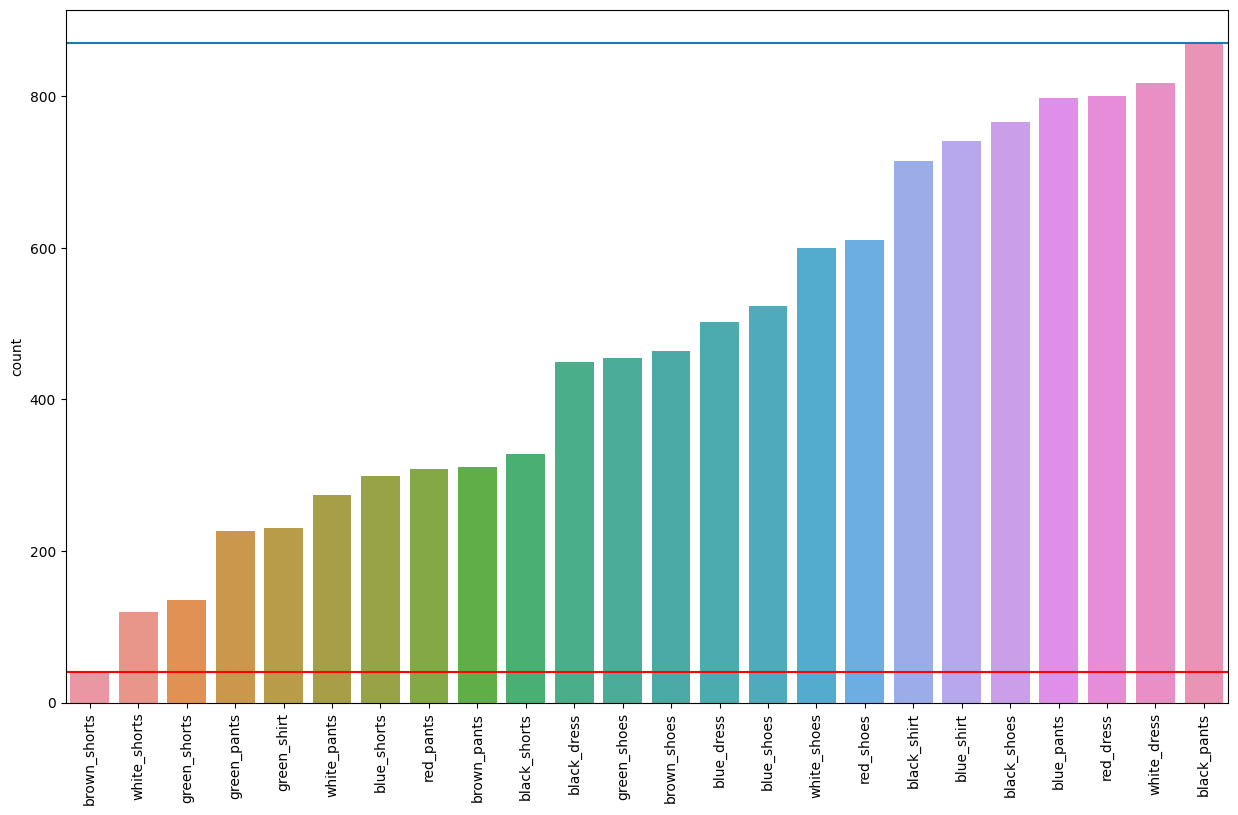

In [ ]:
max_level = True
min_level = True
plt.figure(figsize=(15, 9))
sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
if max_level:
    plt.axhline(y=max(data['count']))
if min_level:
    plt.axhline(y=min(data['count']), color='red')
plt.show()

Классы нуждаются в балансировке.

## Класс для набора данных и функция кодирования лейблов.

In [ ]:
all_images = list(paths.list_images(Path(config.DIR)))
train_images, val_images = train_test_split(all_images, test_size=.20, random_state=seed)

In [ ]:
def encode_label(label, class_list):
    """Encode a list of labels using one-hot encoding.

    Args:
        label: Label to encode.
        class_list: A list of all possible labels. Defaults to DEFAULT_LABELS.

    Returns:
        A tensor representing the one-hot encoding of the input labels.
    """

    target = torch.zeros(len(class_list))
    for _ in class_list:
        idx = class_list.index(label)

        target[idx] = 1
    return target

In [ ]:
class ApparelDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.transform=transform
        self.image_list=image_list

        self.labels = [re.findall(r'\w+\_\w+', img_path)[0] for img_path in self.image_list]
        self.label = [re.findall(r'\w+\_\w+', img_path)[0].split('_') for img_path in self.image_list]
        self.col_labels = ['black', 'blue', 'brown', 'green', 'red', 'white']
        self.art_labels = ['dress', 'pants', 'shirt', 'shoes', 'shorts']
        self.col_label = [self.col_labels[np.argmax(encode_label(label[0], self.col_labels))] for label in self.label]
        self.art_label = [self.art_labels[np.argmax(encode_label(label[1], self.art_labels))] for label in self.label]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = re.findall(r'\w+\_\w+', img_path)[0]
        labels = re.findall(r'\w+\_\w+', img_path)[0].split('_')
        col_labels = ['black', 'blue', 'brown', 'green', 'red', 'white']
        art_labels = ['dress', 'pants', 'shirt', 'shoes', 'shorts']
        colour_label = encode_label(labels[0], col_labels)
        article_label = encode_label(labels[1], art_labels)
        col_label, art_label = col_labels[np.argmax(colour_label)], art_labels[np.argmax(article_label)]

        return img, np.concatenate([colour_label, article_label]), label, col_label, art_label

Возвращаем картинку, результат конкатенации лейблов и исходные лейблы.

## Преобразования данных.

In [ ]:
seed_torch(seed)

val_transforms = transforms.Compose([
      transforms.Resize(config.IMG_SIZE),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_transforms = transforms.Compose([
      transforms.Resize(config.IMG_SIZE),
      transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
      transforms.RandomRotation(degrees=25, expand=False, center=None),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(p=0.25),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = ApparelDataset(train_images, train_transforms)
val_dataset = ApparelDataset(val_images, val_transforms)

In [ ]:
col = pd.Series(train_dataset.col_label).value_counts().sort_values().to_frame("count")
col

,count
brown,639
green,851
red,1376
white,1456
blue,2284
black,2502


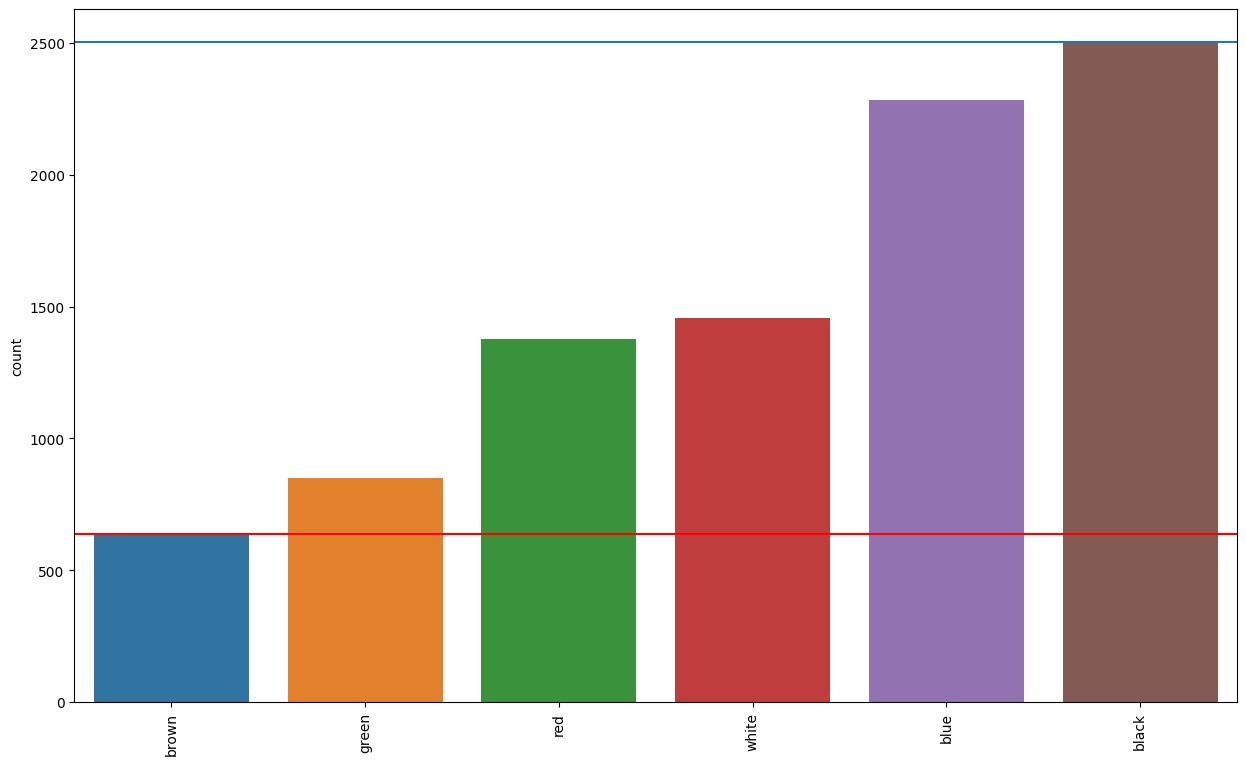

In [ ]:
max_level = True
min_level = True
plt.figure(figsize=(15, 9))
sns.barplot(x=col.index, y=col['count'], orient='v').set_xticklabels(col.index, rotation=90)
if max_level:
    plt.axhline(y=max(col['count']))
if min_level:
    plt.axhline(y=min(col['count']), color='red')
plt.show()

In [ ]:
art = pd.Series(train_dataset.art_label).value_counts().sort_values().to_frame("count")
art

,count
shorts,740
shirt,1352
dress,2061
pants,2232
shoes,2723


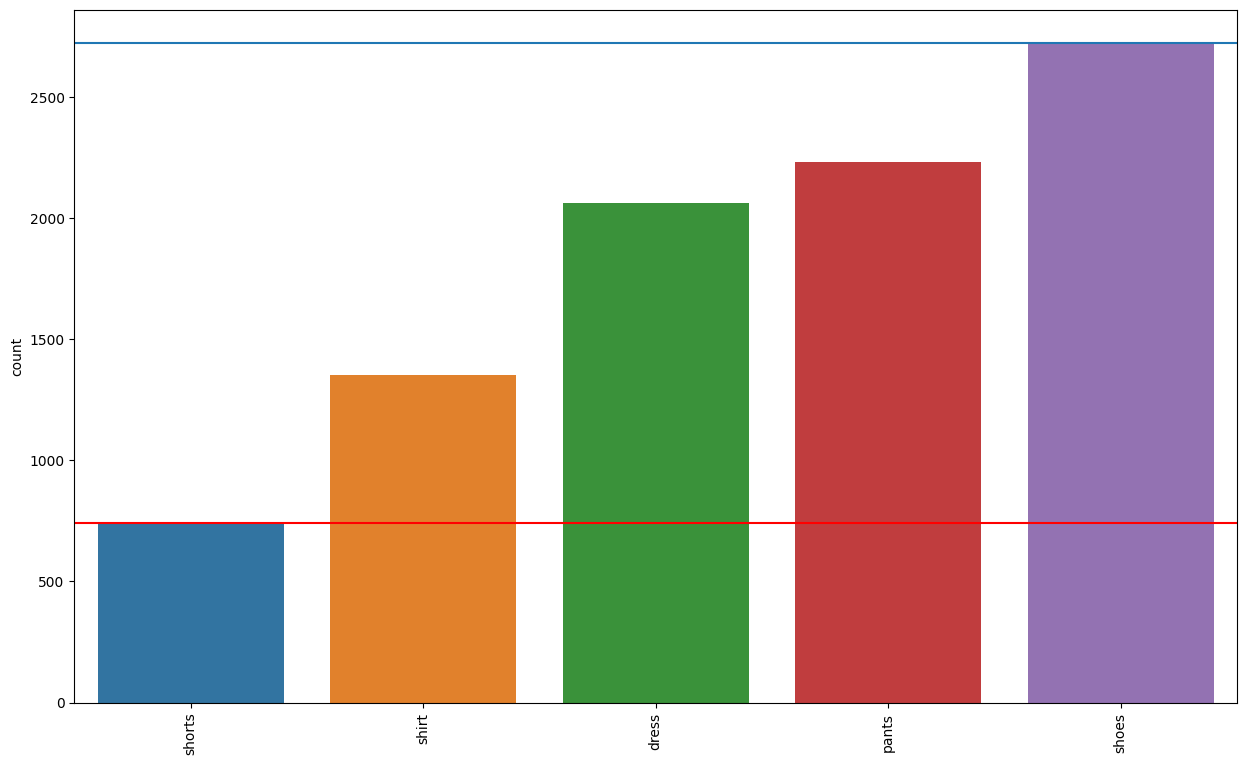

In [ ]:
max_level = True
min_level = True
plt.figure(figsize=(15, 9))
sns.barplot(x=art.index, y=art['count'], orient='v').set_xticklabels(art.index, rotation=90)
if max_level:
    plt.axhline(y=max(art['count']))
if min_level:
    plt.axhline(y=min(art['count']), color='red')
plt.show()

## $Weighted~Random~Sampler$.

### Взвешенная балансировка по цвету одежды.

In [ ]:
seed_torch(seed)

col_count = Counter(train_dataset.col_label)
col_weights = {i: 1/c for i, c in col_count.items()}
sample_weights = [0] * len(train_dataset)
for i, label in enumerate(tqdm(train_dataset.col_label)):
  class_weight = col_weights[label]
  sample_weights[i] = class_weight

N = max(col_count.values()) * len(col_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9108 [00:00<?, ?it/s]

In [ ]:
count = Counter()
cnt_col = Counter()
cnt_art = Counter()

for im, labels, y, col, art in tqdm(train_loader):
  count += Counter(list(y))
  cnt_col += Counter(list(col))
  cnt_art += Counter(list(art))

print(sum(count.values()), count)
print(sum(cnt_col.values()), cnt_col)
print(sum(cnt_art.values()), cnt_art)

  0%|          | 0/118 [00:00<?, ?it/s]

15072 Counter({'brown_shoes': 1412, 'red_dress': 1159, 'white_dress': 1158, 'green_shoes': 1118, 'brown_pants': 954, 'red_shoes': 885, 'white_shoes': 795, 'black_pants': 717, 'blue_pants': 692, 'black_shoes': 666, 'blue_shirt': 655, 'green_shirt': 601, 'green_pants': 579, 'black_shirt': 512, 'blue_shoes': 466, 'blue_dress': 445, 'red_pants': 410, 'white_pants': 376, 'black_dress': 352, 'green_shorts': 296, 'blue_shorts': 270, 'black_shorts': 264, 'white_shorts': 152, 'brown_shorts': 138})
15072 Counter({'green': 2594, 'blue': 2528, 'black': 2511, 'brown': 2504, 'white': 2481, 'red': 2454})
15072 Counter({'shoes': 5342, 'pants': 3728, 'dress': 3114, 'shirt': 1768, 'shorts': 1120})


### Взвешенная балансировка по предмету одежды.

In [ ]:
seed_torch(seed)

art_count = Counter(train_dataset.art_label)
art_weights = {i: 1/c for i, c in art_count.items()}
sample_weights = [0] * len(train_dataset)
for i, label in enumerate(tqdm(train_dataset.art_label)):
  class_weight = art_weights[label]
  sample_weights[i] = class_weight

N = max(art_count.values()) * len(art_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9108 [00:00<?, ?it/s]

In [ ]:
count = Counter()
cnt_col = Counter()
cnt_art = Counter()

for im, labels, y, col, art in tqdm(train_loader):
  count += Counter(list(y))
  cnt_col += Counter(list(col))
  cnt_art += Counter(list(art))

print(sum(count.values()), count)
print(sum(cnt_col.values()), cnt_col)
print(sum(cnt_art.values()), cnt_art)

  0%|          | 0/108 [00:00<?, ?it/s]

13740 Counter({'blue_shirt': 1177, 'black_shirt': 1109, 'black_shorts': 1024, 'blue_shorts': 915, 'white_dress': 894, 'red_dress': 880, 'black_pants': 873, 'blue_pants': 789, 'black_shoes': 615, 'blue_dress': 512, 'black_dress': 512, 'red_shoes': 476, 'white_shoes': 472, 'blue_shoes': 424, 'green_shorts': 397, 'brown_shoes': 368, 'green_shoes': 362, 'green_shirt': 352, 'red_pants': 333, 'brown_pants': 306, 'white_shorts': 303, 'white_pants': 262, 'green_pants': 257, 'brown_shorts': 128})
13740 Counter({'black': 4133, 'blue': 3817, 'white': 1931, 'red': 1689, 'green': 1368, 'brown': 802})
13740 Counter({'pants': 2820, 'dress': 2798, 'shorts': 2767, 'shoes': 2717, 'shirt': 2638})


### Взвешенная баласировка комбинациям лейблов.

In [ ]:
seed_torch(seed)

class_count = Counter(train_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, label in enumerate(tqdm(train_dataset.labels)):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)

train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/9108 [00:00<?, ?it/s]

In [ ]:
count = Counter()
cnt_col = Counter()
cnt_art = Counter()

for im, labels, y, col, art in tqdm(train_loader):
  count += Counter(list(y))
  cnt_col += Counter(list(col))
  cnt_art += Counter(list(art))

print(sum(count.values()), count)
print(sum(cnt_col.values()), cnt_col)
print(sum(cnt_art.values()), cnt_art)

  0%|          | 0/131 [00:00<?, ?it/s]

16704 Counter({'blue_shirt': 759, 'green_shirt': 744, 'green_shoes': 729, 'red_pants': 725, 'green_shorts': 725, 'black_shoes': 722, 'blue_shoes': 713, 'black_pants': 711, 'brown_shoes': 707, 'blue_dress': 705, 'white_shoes': 696, 'black_shorts': 695, 'green_pants': 693, 'red_dress': 691, 'white_dress': 686, 'brown_shorts': 683, 'white_pants': 680, 'black_shirt': 680, 'red_shoes': 679, 'white_shorts': 679, 'blue_shorts': 658, 'black_dress': 654, 'blue_pants': 652, 'brown_pants': 638})
16704 Counter({'blue': 3487, 'black': 3462, 'green': 2891, 'white': 2741, 'red': 2095, 'brown': 2028})
16704 Counter({'shoes': 4246, 'pants': 4099, 'shorts': 3440, 'dress': 2736, 'shirt': 2183})


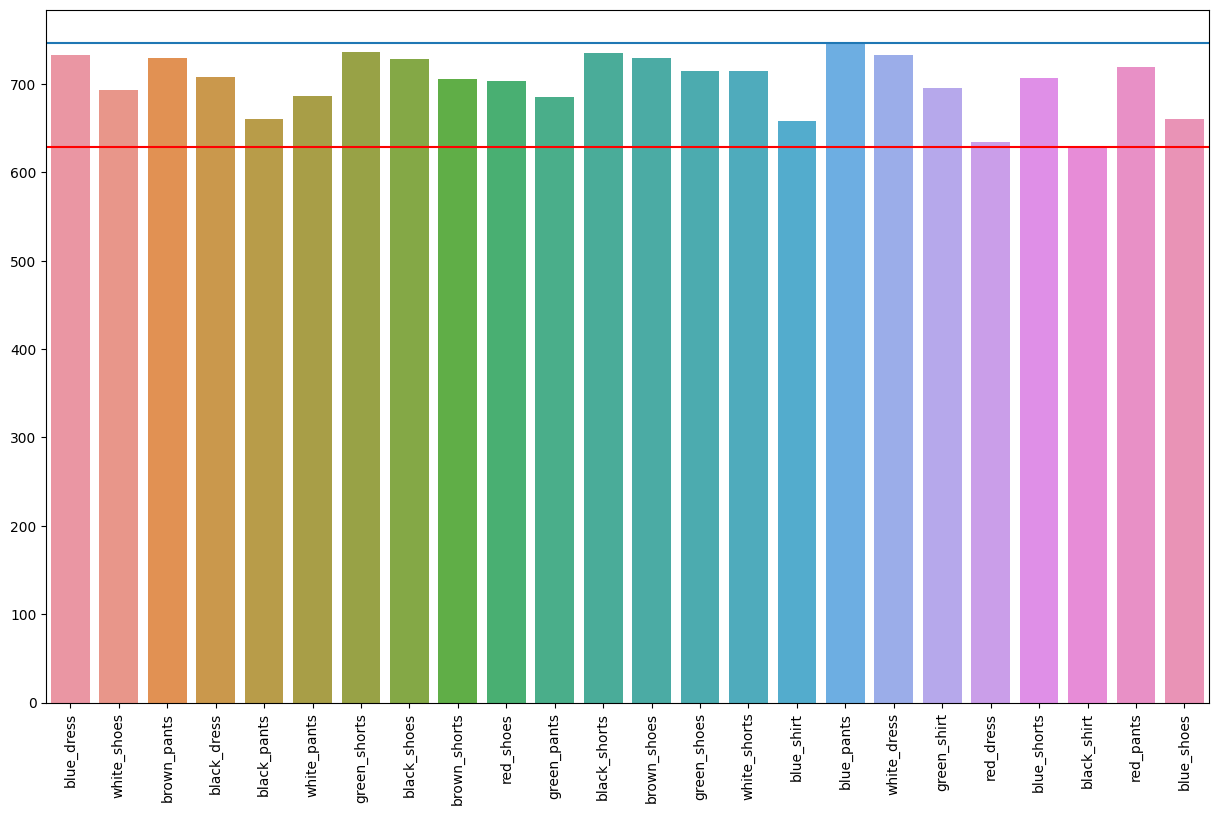

In [ ]:
d = pd.Series(count)
max_level = True
min_level = True
plt.figure(figsize=(15, 9))
sns.barplot(x=d.index, y=d, orient='v').set_xticklabels(d.index, rotation=90)
if max_level:
    plt.axhline(y=max(d))
if min_level:
    plt.axhline(y=min(d), color='red')
plt.show()

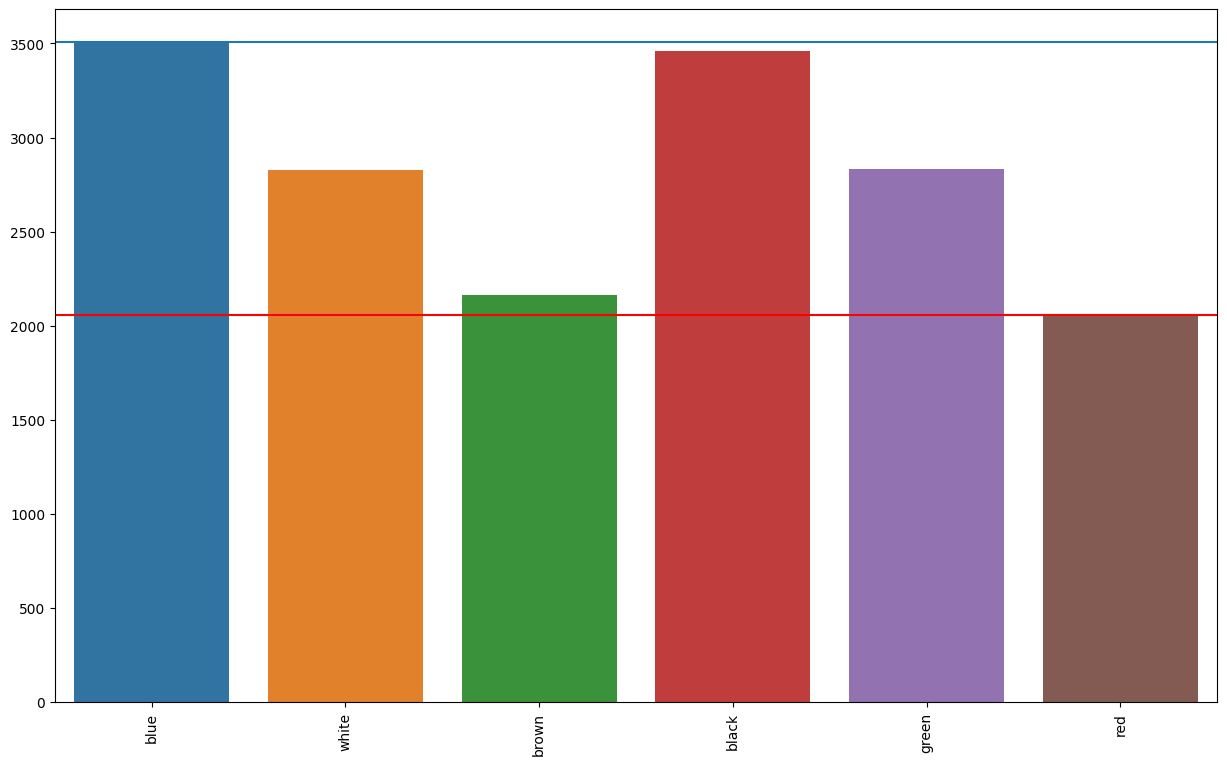

In [ ]:
c = pd.Series(cnt_col)
max_level = True
min_level = True
plt.figure(figsize=(15, 9))
sns.barplot(x=c.index, y=c, orient='v').set_xticklabels(c.index, rotation=90)
if max_level:
    plt.axhline(y=max(c))
if min_level:
    plt.axhline(y=min(c), color='red')
plt.show()

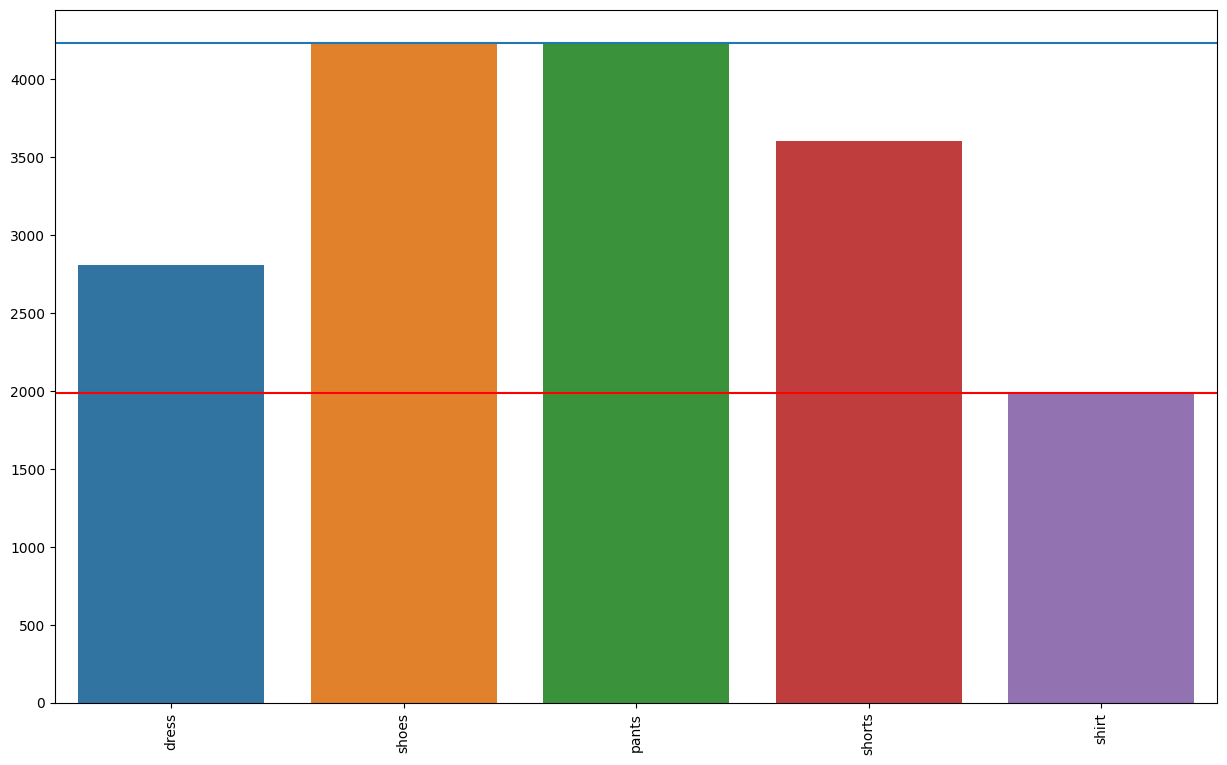

In [ ]:
a = pd.Series(cnt_art)
max_level = True
min_level = True
plt.figure(figsize=(15, 9))
sns.barplot(x=a.index, y=a, orient='v').set_xticklabels(a.index, rotation=90)
if max_level:
    plt.axhline(y=max(a))
if min_level:
    plt.axhline(y=min(a), color='red')
plt.show()

Теперь лучше, распределение ближе к равномерному, но только по комбинации лейблов, поэтому в качестве метрики $Accuracy$ лучше не использовать. Просто сделали аугментацию данных.

## Визуализация нескольких сэмплов.

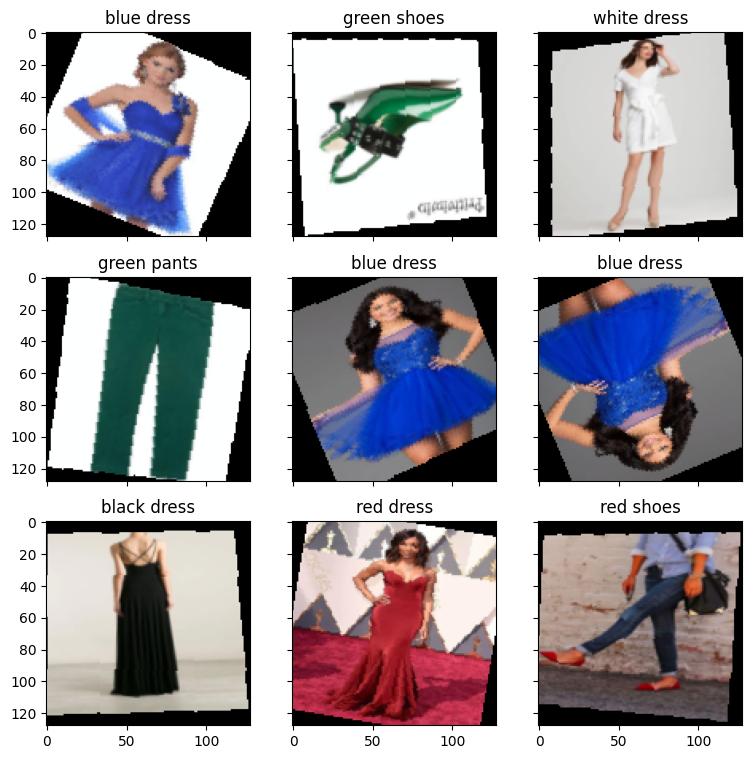

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True, nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(len(train_dataset)), dtype='int').item()
    img, label, lab, col, art = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(lab.split('_')))
    figx.imshow(img)

# 2. Обучение модели.

## Функция потерь.

Учитывая, что мы закодировали все лейблы нулями и единицами, то можно воспользоваться функцией бинарной кросс-энтропии, которая задаётся следующим образом:
$$
BCE(y, \hat y) = -\sum_i \left[y_i\cdot\log\sigma(\hat y_i) + (1-y_i)\cdot\log(1-\sigma(\hat y_i))\right],
$$
где $y~-~$это таргет желаемого результата; $\hat y~-~$является выходом модели. $\sigma~-~$это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), которая преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Отметим, что данная функция потерь страдает от проблем с численной нестабильностью $-~\lim_{x\rightarrow0}\log(x)=\infty$. Что приводит к неустойчивости в процессе оптимизации. Однако если попробовать упростить данное выражение, то можно перейти к более [стабильной версии](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) кросс энтропийной функции:
$$
BCE(y, \hat y) = -\sum_i \left[y_i\cdot\log\sigma(\hat y_i) + (1-y_i)\cdot\log(1-\sigma(\hat y_i))\right]=\sum_i\left[y_i\cdot\left(-\log \frac{1}{1+\exp(-\hat{y_i})}\right)+(1-y_i)\cdot\left(-\log \frac{\exp(-\hat{y_i})}{1+\exp(\hat{-y_i})}\right)\right]=\sum_i \left[y_i\cdot\log(1+\exp(-\hat{y_i}))+(1-y_i)\cdot(-\log (\exp(-\hat{y_i})))+\log (1+\exp(-\hat{y_i}))\right]=\sum_i \left[y_i\cdot\log(1+\exp(-\hat{y_i}))+(1-y_i)\cdot(\hat{y_i}+\log(1+\exp(-\hat{y_i})))\right].
$$

В итоге получаем:
$$
BCE(y, \hat y)=\sum_i \left[\hat{y_i}-\hat{y_i} \cdot y_i+\log(1+\exp(-\hat{y_i}))\right].
$$

А итоговую функцию потерь для задачи мульти-лейбл классификации зададим следующим образом:

$$
\mathcal{L}(y, \hat{y})=\frac{BCE_{color}(y_{color}, \hat{y}_{color})+BCE_{article}(y_{article}, \hat{y}_{article})}{2},
$$

где $BCE_{color}~-~$ошибка бинарной кросс-энтропии по цвету одежды; $BCE_{article}~-~$ошибка бинарной кросс-энтропии по предмету одежды.

In [ ]:
def custom_loss(y_pcol, y_col, y_part, y_art):

    col_loss = (y_pcol - y_col * y_pcol + (1 + torch.exp(-y_pcol)).log()).mean()
    art_loss = (y_part - y_art * y_part + (1 + torch.exp(-y_part)).log()).mean()

    return (col_loss + art_loss) / 2

## Метрика.

Как уже говорилось ранее, использовать в качестве метрики $Accuracy$ не стоит, т.к. невозможно сбалансировать и предметные, и цветовые лейблы, ведь изначально они были едины, т.е. балансируя один лейбл, дисбалансируем другой $-$ и так по кругу. Можно было бы, конечно, найти наиболее "красивый" вариант балансировки, но в целом сбалансировать по изначальным классам, вполне возможно, тоже неплохая идея.

В качестве метрики будем использовать $F1$-$score$:

$$
F1 = (1+\beta^{2}) \cdot \frac{Precision \cdot Recall}{(\beta^{2} \cdot Precision)+Recall}
$$

Заметим, что задача классификации одежды такова, что никто не умирает, если мы ошибаемся. Поэтому $Recall$ нам менее важен, нежели $Precision$, поэтому возьмём коэффициент $\beta=0.5~-~$будем считать, что нам важнее точность ($Precision$).

In [ ]:
def f1_score_with_beta(y_pcol, y_col, y_part, y_art, beta=0.5, eps=1e-12):

    y_pcol = y_pcol > 0.5
    y_part = y_part > 0.5
    y_col = y_col > 0.5
    y_art = y_art > 0.5

    col_TP = (y_pcol & y_col).sum(1).float()
    col_TN = ((~y_pcol) & (~y_col)).sum(1).float()
    col_FP = (y_pcol & (~y_col)).sum(1).float()
    col_FN = ((~y_pcol) & y_col).sum(1).float()

    art_TP = (y_part & y_art).sum(1).float()
    art_TN = ((~y_part) & (~y_art)).sum(1).float()
    art_FP = (y_part & (~y_art)).sum(1).float()
    art_FN = ((~y_part) & y_art).sum(1).float()

    TP = (col_TP + art_TP) / 2
    TN = (col_TN + art_TN) / 2
    FP = (col_FP + art_FP) / 2
    FN = (col_FN + art_FN) / 2

    precision = torch.mean(TP / (TP + FP + eps))
    recall = torch.mean(TP / (TP + FN + eps))

    f1_score_with_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + eps)

    return f1_score_with_beta.mean(0)

## Архитектура модели.

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class MyResNet15(nn.Module):
    def __init__(self, in_channels, num_classes, config):
        super().__init__()
        #input 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.colour = nn.Sequential(nn.Dropout(config.DROPOUT),
                                     nn.Linear(1024, config.N_COLOUR_LABELS),
                                     nn.Softmax(dim=1))
        self.article = nn.Sequential(nn.Dropout(config.DROPOUT),
                                      nn.Linear(1024, config.N_ARTICLE_LABELS),
                                      nn.Softmax(dim=1))

    def forward(self, x):
        out = self.conv1(x)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.avgpool(out)
        predicted_colour = self.colour(out.view(out.size(0), -1))
        predicted_article = self.article(out.view(out.size(0), -1))
        pred_tensor = torch.cat([predicted_colour, predicted_article], dim=1)
        return pred_tensor

In [ ]:
from torchinfo import summary

seed_torch(seed)
model = MyResNet15(3, config.N_COLOUR_LABELS+config.N_ARTICLE_LABELS, config).to(DEVICE)
summary(model, (1, 3, 128, 128), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet15                               [1, 11]                   --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
├─Sequential: 1-2                        [1, 64, 128, 128]         --
│    └─Sequential: 2-4                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    └─Sequential: 2-5                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│

In [ ]:
seed_torch(seed)
optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=config.BETAS)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.STEP_SIZE, gamma=config.GAMMA)

## $Sweeps$.

In [ ]:
len(train_loader.sampler)%config.BATCH_SIZE, len(val_loader.sampler)%config.BATCH_SIZE

(64, 101)

Итак, наши выборки не делятся нацело на $128$, поэтому в процессе обучения и валидации будем взвешивать лосс $\mathcal{L}_{i}$ на величину размера батча $batchsize_{i}$, а при подсчёте лосса за эпоху отнормируем на количество экземпляров в выборке $N$:

$$
\mathcal{L}_{average}=\frac{1}{N}\sum\limits_{i=1}^{N} \mathcal{L}_{i} \cdot batchsize_{i}.
$$

In [ ]:
def train():
    # Инициализация wandb
    wandb.init()

    # Загрузка и предобработка данных
    val_transforms = transforms.Compose([
          transforms.Resize(config.IMG_SIZE),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_transforms = transforms.Compose([
          transforms.Resize(config.IMG_SIZE),
          transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
          transforms.RandomRotation(degrees=25, expand=False, center=None),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(p=0.25),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_dataset = ApparelDataset(train_images, train_transforms)
    val_dataset = ApparelDataset(val_images, val_transforms)

    class_count = Counter(train_dataset.labels)
    class_weights = {i: 1/c for i, c in class_count.items()}
    sample_weights = [0] * len(train_dataset)
    for i, label in enumerate(tqdm(train_dataset.labels)):
      class_weight = class_weights[label]
      sample_weights[i] = class_weight

    N = max(class_count.values()) * len(class_count)

    train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

    model = MyResNet15(3, config.N_COLOUR_LABELS+config.N_ARTICLE_LABELS, config).to(DEVICE)

    # Определение птимизатора
    optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=config.BETAS)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.STEP_SIZE, gamma=config.GAMMA)

    # Обучение и валидация модели
    pbar = trange(epochs, desc='Epoch:')
    for epoch in pbar:
        tr_loss = 0
        tr_f1 = 0
        model.train()
        for image, targets, labels, col, art in tqdm(train_loader):
            X_batch, y_batch = image.to(DEVICE), torch.as_tensor(targets, dtype=torch.long).to(DEVICE)
            y_col = y_batch[:, :config.N_COLOUR_LABELS]
            y_art = y_batch[:, config.N_COLOUR_LABELS:]
            optimizer.zero_grad()
            # Forward
            y_pred = model(X_batch).to(DEVICE)
            y_pcol = y_pred[:, :config.N_COLOUR_LABELS]
            y_part = y_pred[:, config.N_COLOUR_LABELS:]
            loss = custom_loss(y_pcol, y_col, y_part, y_art)
            # Backward
            loss.backward()
            optimizer.step()

            tr_loss += loss.item() * X_batch.size(0)
            tr_f1 += f1_score_with_beta(y_pcol, y_col, y_part, y_art)


        train_loss = tr_loss / len(train_loader.sampler)
        train_f1 = tr_f1 / len(train_loader)
        print(train_loss, train_f1)
        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_f1": train_f1})

In [ ]:
def sweep_train():
    sweep_config = {
        'method': 'random',
        'metric': {
            'name': 'accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'learning_rate': {
                'values': [0.001, 0.0001]
            },
            'batch_size': {
                'values': [64, 128]   # хотел попробовать 256, но по видеопамяти не будет проходит на следующем этапе
            },
            'dropout': {
                'values': [0.1, 0.15, 0.2]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project="apparel_sweeps")
    wandb.agent(sweep_id, train)

In [ ]:
# Запуск Sweeps
seed_torch(seed)
epochs = 3
sweep_train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 60dq0k49
Sweep URL: https://wandb.ai/vlad-gad/apparel_sweeps/sweeps/60dq0k49


wandb: Agent Starting Run: sfh9m3r5 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6632888806697405 tensor(0.7983, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6448788917280996 tensor(0.8922, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6404220700947125 tensor(0.9152, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91521
train_loss,0.64042


wandb: Agent Starting Run: kbqtrraj with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.664100029919414 tensor(0.7957, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6445591308553672 tensor(0.8947, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6400435443366268 tensor(0.9183, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91832
train_loss,0.64004


wandb: Agent Starting Run: tdxtw2zs with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6652907668234853 tensor(0.7880, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6446297416372764 tensor(0.8948, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6402881868475374 tensor(0.9155, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91545
train_loss,0.64029


wandb: Agent Starting Run: ggxua7np with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6660525259110852 tensor(0.7850, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.645370576591182 tensor(0.8906, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6408361034839634 tensor(0.9124, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91241
train_loss,0.64084


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eba8zpyy with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6661532866806789 tensor(0.7848, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6468785483151702 tensor(0.8820, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6412695981028428 tensor(0.9107, device='cuda:0')


epoch,▁▅█
train_f1,▁▆█
train_loss,█▃▁
epoch,2
train_f1,0.91067
train_loss,0.64127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: isye1wf6 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6655388788143111 tensor(0.7859, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6464535046329699 tensor(0.8853, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6411593338935401 tensor(0.9113, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▃▁
epoch,2
train_f1,0.91134
train_loss,0.64116


wandb: Agent Starting Run: ieps024h with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6648448452908535 tensor(0.7896, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6457002362184788 tensor(0.8897, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6404656212787574 tensor(0.9138, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▃▁
epoch,2
train_f1,0.91378
train_loss,0.64047


wandb: Agent Starting Run: vvcm07zz with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6661064960098084 tensor(0.7844, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6462265554790624 tensor(0.8862, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6404329530944569 tensor(0.9149, device='cuda:0')


epoch,▁▅█
train_f1,▁▆█
train_loss,█▃▁
epoch,2
train_f1,0.91487
train_loss,0.64043


wandb: Agent Starting Run: pbm97n0s with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6652229708381915 tensor(0.7870, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6454015087261582 tensor(0.8905, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6405862845345236 tensor(0.9149, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91493
train_loss,0.64059


wandb: Agent Starting Run: fw36gqh8 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6689008193120801 tensor(0.7674, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6462683265507506 tensor(0.8859, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6406872509316023 tensor(0.9143, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.9143
train_loss,0.64069


wandb: Agent Starting Run: 0fk5irlv with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6651124116229009 tensor(0.7895, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6465697123419134 tensor(0.8840, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6406102549380764 tensor(0.9139, device='cuda:0')


epoch,▁▅█
train_f1,▁▆█
train_loss,█▃▁
epoch,2
train_f1,0.9139
train_loss,0.64061


wandb: Agent Starting Run: r47n7ms3 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6649752874087468 tensor(0.7895, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6452457642942354 tensor(0.8907, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6400607107589671 tensor(0.9162, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91618
train_loss,0.64006


wandb: Agent Starting Run: dplb4u7z with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6641546191208229 tensor(0.7942, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6450723909489177 tensor(0.8921, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6406803753906585 tensor(0.9141, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91406
train_loss,0.64068


wandb: Agent Starting Run: ya138p1d with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6661718721717681 tensor(0.7833, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6463294042898796 tensor(0.8855, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6412743317477455 tensor(0.9103, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91028
train_loss,0.64127


wandb: Agent Starting Run: g4q43w0p with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.664559961617733 tensor(0.7930, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6469670605864429 tensor(0.8821, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6415598088485805 tensor(0.9090, device='cuda:0')


epoch,▁▅█
train_f1,▁▆█
train_loss,█▃▁
epoch,2
train_f1,0.90899
train_loss,0.64156


wandb: Agent Starting Run: zc5h9s5y with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6648690057233503 tensor(0.7904, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6443077673657006 tensor(0.8960, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6403055555954817 tensor(0.9159, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91591
train_loss,0.64031


wandb: Agent Starting Run: 8kfhq3l4 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6664968022530491 tensor(0.7822, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6460359464288327 tensor(0.8873, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6407619727830605 tensor(0.9138, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91375
train_loss,0.64076


wandb: Agent Starting Run: sxfivkxh with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


  0%|          | 0/9108 [00:00<?, ?it/s]

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

0.6643482177396445 tensor(0.7934, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6449118049347412 tensor(0.8925, device='cuda:0')


  0%|          | 0/131 [00:00<?, ?it/s]

0.6409927267855196 tensor(0.9125, device='cuda:0')


epoch,▁▅█
train_f1,▁▇█
train_loss,█▂▁
epoch,2
train_f1,0.91246
train_loss,0.64099


wandb: Agent Starting Run: dtkhnwv4 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.15
wandb: 	learning_rate: 0.0001


wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fcb0c2276a0>> (for post_run_cell):


BrokenPipeError: ignored

**Я прервал свип.**

## Обучение модели

In [ ]:
config.LR = 1e-4
config.BATCH_SIZE = 128
config.DROPOUT = 0.1

In [ ]:
from torchinfo import summary

seed_torch(seed)
model = MyResNet15(3, config.N_COLOUR_LABELS+config.N_ARTICLE_LABELS, config).to(DEVICE)
summary(model, (1, 3, 128, 128), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet15                               [1, 11]                   --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
├─Sequential: 1-2                        [1, 64, 128, 128]         --
│    └─Sequential: 2-4                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    └─Sequential: 2-5                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│

In [ ]:
seed_torch(seed)
optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=config.BETAS)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.STEP_SIZE, gamma=config.GAMMA)

In [ ]:
seed_torch(seed)

class_count = Counter(train_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, label in enumerate(tqdm(train_dataset.labels)):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)

train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/9108 [00:00<?, ?it/s]

In [ ]:
len(train_loader.sampler)%config.BATCH_SIZE, len(val_loader)%config.BATCH_SIZE

(112, 18)

Также будем взвешивать значения функции потерь на каждом батче, а при подсчёте среднего лосса по эпохе нормировать на колчиество экземпляров в выборке.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# config.BM_WEIGHTS = '/content/gdrive/MyDrive/project/best_model_weights'

Mounted at /content/gdrive/


In [ ]:
def show_some_samples(model, loader, config):
    for image, targets, labels, col, art in loader:
        model.eval()
        with torch.no_grad():
            target_image_pred = model(image.to(DEVICE))

        col = torch.argmax(target_image_pred[:, :config.N_COLOUR_LABELS], dim=1)
        art = torch.argmax(target_image_pred[:, config.N_COLOUR_LABELS:], dim=1)


        probs_col = torch.max(target_image_pred[:, :config.N_COLOUR_LABELS], dim=1)
        probs_art = torch.max(target_image_pred[:, config.N_COLOUR_LABELS:], dim=1)

        num_samples = 9
        ground_truth = [label.replace('_', ' ') for label in labels]
        plt.subplots(figsize=(23, 15))
        rows, cols = 3, 3
        for i in range(num_samples // rows):
            predicted_color = config.COLOUR_LABELS[col[i]]
            predicted_article = config.ARTICLE_LABELS[art[i]]
            target_image_pred_label = predicted_color + ' ' +  predicted_article

            plt.subplot(rows, cols, i+1)
            plt.imshow(image[i].permute(1, 2, 0))
            title = f"Ground Truth: {ground_truth[i]} \n Prediction: {target_image_pred_label} \n {predicted_article}: {round(probs_art[0][i].item() * 100, 2)}%. {predicted_color}: {round(probs_art[0][i].item() * 100, 2)}%"
            plt.title(title)
            plt.axis(False)

            predicted_color = config.COLOUR_LABELS[col[i+3]]
            predicted_article = config.ARTICLE_LABELS[art[i+3]]
            target_image_pred_label = predicted_color + ' ' +  predicted_article
            plt.subplot(rows, cols, i+3+1)
            plt.imshow(image[i+3].permute(1, 2, 0))
            title = f"Ground Truth: {ground_truth[i+3]} \n Prediction: {target_image_pred_label} \n {predicted_article}: {round(probs_art[0][i+3].item() * 100, 2)}%. {predicted_color}: {round(probs_art[0][i+3].item() * 100, 2)}%"
            plt.title(title)
            plt.axis(False)

            predicted_color = config.COLOUR_LABELS[col[i+3*2]]
            predicted_article = config.ARTICLE_LABELS[art[i+3*2]]
            target_image_pred_label = predicted_color + ' ' +  predicted_article
            plt.subplot(rows, cols, i+3*2+1)
            plt.imshow(image[i+6].permute(1, 2, 0))
            title = f"Ground Truth: {ground_truth[i+3*2]} \n Prediction: {target_image_pred_label} \n {predicted_article}: {round(probs_art[0][i+3*2].item() * 100, 2)}%. {predicted_color}: {round(probs_art[0][i+3*2].item() * 100, 2)}%"
            plt.title(title)
            plt.axis(False)

        break

In [ ]:
def train(model, train_loader, val_loader, optimizer, scheduler, epochs, config):
    since = time()

    train_losses = []
    val_losses = []
    train_full_f1 = []
    val_full_f1 = []
    best_f1 = 0.0

    pbar = trange(epochs, desc='Epoch:')
    for epoch in pbar:
        print('-------------------- Epoch %d/%d --------------------' % (epoch+1, epochs))
        # Train
        tr_loss = 0
        tr_f1 = 0
        model.train()
        for image, targets, labels, col, art in tqdm(train_loader):
            X_batch, y_batch = image.to(DEVICE), torch.as_tensor(targets, dtype=torch.long).to(DEVICE)
            y_col = y_batch[:, :config.N_COLOUR_LABELS]
            y_art = y_batch[:, config.N_COLOUR_LABELS:]
            optimizer.zero_grad()
            # Forward
            y_pred = model(X_batch).to(DEVICE)
            y_pcol = y_pred[:, :config.N_COLOUR_LABELS]
            y_part = y_pred[:, config.N_COLOUR_LABELS:]
            loss = custom_loss(y_pcol, y_col, y_part, y_art)
            # Backward
            loss.backward()
            optimizer.step()

            tr_loss += loss.item() * X_batch.size(0)
            tr_f1 += f1_score_with_beta(y_pcol, y_col, y_part, y_art)

        optimizer.step()
        train_loss = tr_loss / len(train_loader.sampler)
        train_losses.append(train_loss)
        train_f1 = tr_f1 / len(train_loader)
        train_full_f1.append(train_f1.cpu().detach().numpy())
        print('Train loss =', train_loss)
        print('Train F1-score = {:.2f}%'.format(train_f1.item() * 100))
        # Validation
        model.eval()
        v_loss = 0
        v_f1 = 0
        with torch.no_grad():
            for image, targets, labels, col, art in tqdm(val_loader):
                X_val, y_val = image.to(DEVICE), targets.to(DEVICE)
                y_col = y_val[:, :config.N_COLOUR_LABELS]
                y_art = y_val[:, config.N_COLOUR_LABELS:]

                y_pred = model(X_val).to(DEVICE)
                y_pcol = y_pred[:, :config.N_COLOUR_LABELS]
                y_part = y_pred[:, config.N_COLOUR_LABELS:]
                loss = custom_loss(y_pcol, y_col, y_part, y_art)
                v_loss += loss.item() * X_val.size(0)
                v_f1 += f1_score_with_beta(y_pcol, y_col, y_part, y_art)

        val_loss = v_loss / len(val_loader.sampler)
        val_losses.append(val_loss)
        val_f1 = v_f1 / len(val_loader)
        val_full_f1.append(val_f1.cpu().detach().numpy())
        print('Val loss =', val_loss)
        print('Val F1-score = {:.2f}%'.format(val_f1.item() * 100))

        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_f1": train_f1,
                   "val_loss": val_loss, "val_f1": val_f1})

        if val_f1 > best_f1:
            best_f1 = val_f1
            # torch.save(model.state_dict(), os.path.join(config.BM_WEIGHTS, 'Best_model_' + str(epoch+1) + '.pth'))
            torch.save(model.state_dict(), "best_model.pth")
            best_model_weights = deepcopy(model.state_dict())
            wandb.save("best_model.pth")
            print('Save best model!')

        scheduler.step()
        print(f'Time: {(time() - since)}')

    show_some_samples(model, val_loader, config)

    plt.subplots(figsize=(23, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train loss')
    plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    best_ep = np.argmin(val_losses) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('Losses')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(train_full_f1) + 1), train_full_f1, label='train F1')
    plt.plot(np.arange(1, len(val_full_f1) + 1), val_full_f1, label='val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    best_ep = np.argmax(val_full_f1) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='lower right')
    plt.title('Scores')

    plt.show()

    return best_model_weights, train_losses, val_losses, train_full_f1, val_full_f1

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

-------------------- Epoch 1/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6644304796071312
Train F1-score = 79.25%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6683350655139408
Val F1-score = 75.89%
Save best model!
Time: 122.5351493358612
-------------------- Epoch 2/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6451498001329993
Train F1-score = 89.15%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6449146291693418
Val F1-score = 89.25%
Save best model!
Time: 245.99475932121277
-------------------- Epoch 3/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6399460627902887
Train F1-score = 91.75%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6420231979564454
Val F1-score = 90.65%
Save best model!
Time: 369.16549158096313
-------------------- Epoch 4/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6351582615742142
Train F1-score = 94.25%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6365801993827837
Val F1-score = 93.29%
Save best model!
Time: 491.5775465965271
-------------------- Epoch 5/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6337621726074328
Train F1-score = 94.88%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6366453412126751
Val F1-score = 93.32%
Save best model!
Time: 614.5835127830505
-------------------- Epoch 6/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6329018502658964
Train F1-score = 95.36%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6358789016816194
Val F1-score = 93.59%
Save best model!
Time: 738.8079166412354
-------------------- Epoch 7/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6313361305789711
Train F1-score = 96.18%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6348858862840454
Val F1-score = 94.14%
Save best model!
Time: 862.084451675415
-------------------- Epoch 8/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6306295192799573
Train F1-score = 96.44%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.631863953908075
Val F1-score = 95.75%
Save best model!
Time: 985.3253190517426
-------------------- Epoch 9/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6303080585078046
Train F1-score = 96.65%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6312227675042552
Val F1-score = 96.07%
Save best model!
Time: 1107.9736857414246
-------------------- Epoch 10/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6291032633330556
Train F1-score = 97.28%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6318689189461903
Val F1-score = 95.71%
Time: 1230.0309748649597
-------------------- Epoch 11/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6288850611465366
Train F1-score = 97.38%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6313781532007819
Val F1-score = 96.03%
Time: 1353.4699420928955
-------------------- Epoch 12/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6284507062168723
Train F1-score = 97.60%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6312084952414324
Val F1-score = 95.97%
Time: 1477.4653611183167
-------------------- Epoch 13/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6280011539814465
Train F1-score = 97.84%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6307373540308269
Val F1-score = 96.28%
Save best model!
Time: 1601.142864227295
-------------------- Epoch 14/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.627828885855397
Train F1-score = 97.91%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.63045201963325
Val F1-score = 96.52%
Save best model!
Time: 1724.5812056064606
-------------------- Epoch 15/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6274822685074101
Train F1-score = 98.16%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.630609414846582
Val F1-score = 96.35%
Time: 1847.1419155597687
-------------------- Epoch 16/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6274109921687654
Train F1-score = 98.16%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6303928597328377
Val F1-score = 96.45%
Time: 1970.3310301303864
-------------------- Epoch 17/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6274451636767091
Train F1-score = 98.10%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6305230554384677
Val F1-score = 96.31%
Time: 2094.081921815872
-------------------- Epoch 18/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6270386758255981
Train F1-score = 98.34%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6303029198577439
Val F1-score = 96.37%
Time: 2218.5254843235016
-------------------- Epoch 19/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6270462576274999
Train F1-score = 98.34%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6302562354686336
Val F1-score = 96.54%
Save best model!
Time: 2341.9266228675842
-------------------- Epoch 20/20 --------------------


  0%|          | 0/131 [00:00<?, ?it/s]

Train loss = 0.6270666804445735
Train F1-score = 98.28%


  0%|          | 0/18 [00:00<?, ?it/s]

Val loss = 0.6300507508509505
Val F1-score = 96.68%
Save best model!
Time: 2465.663381576538


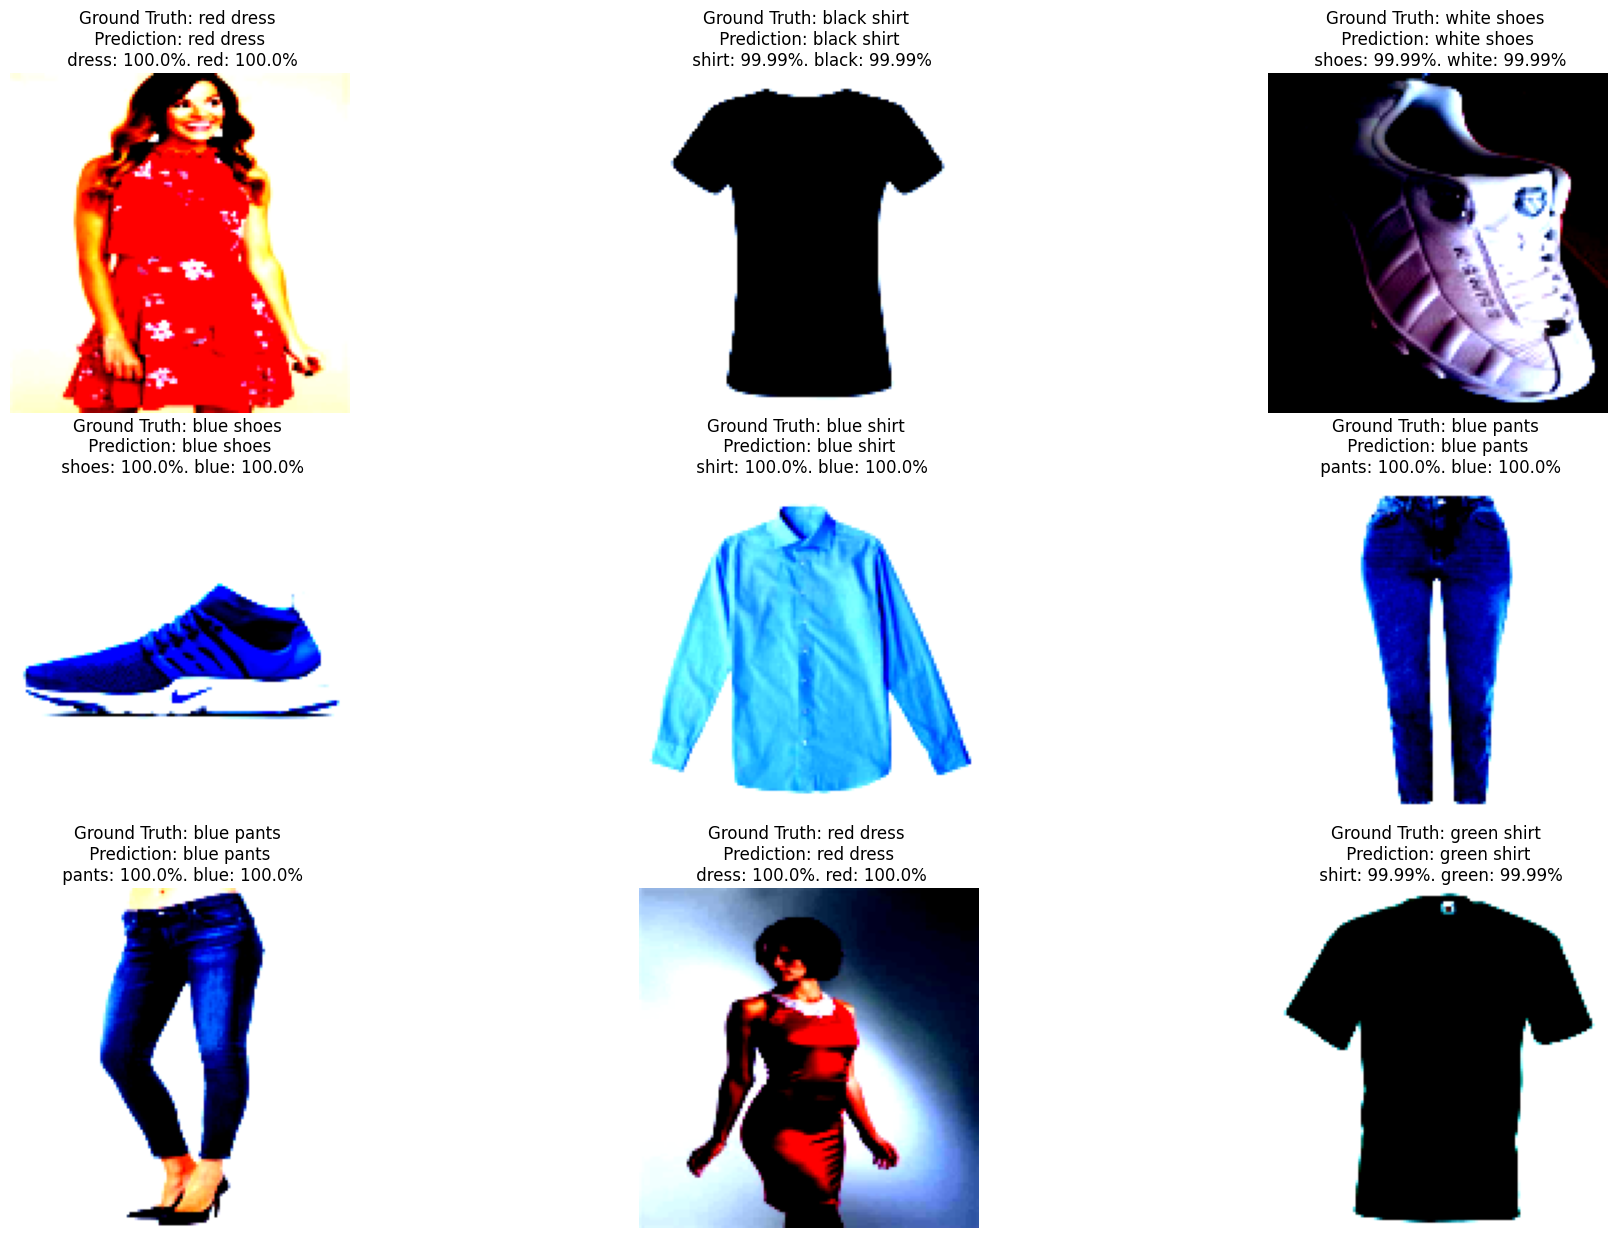

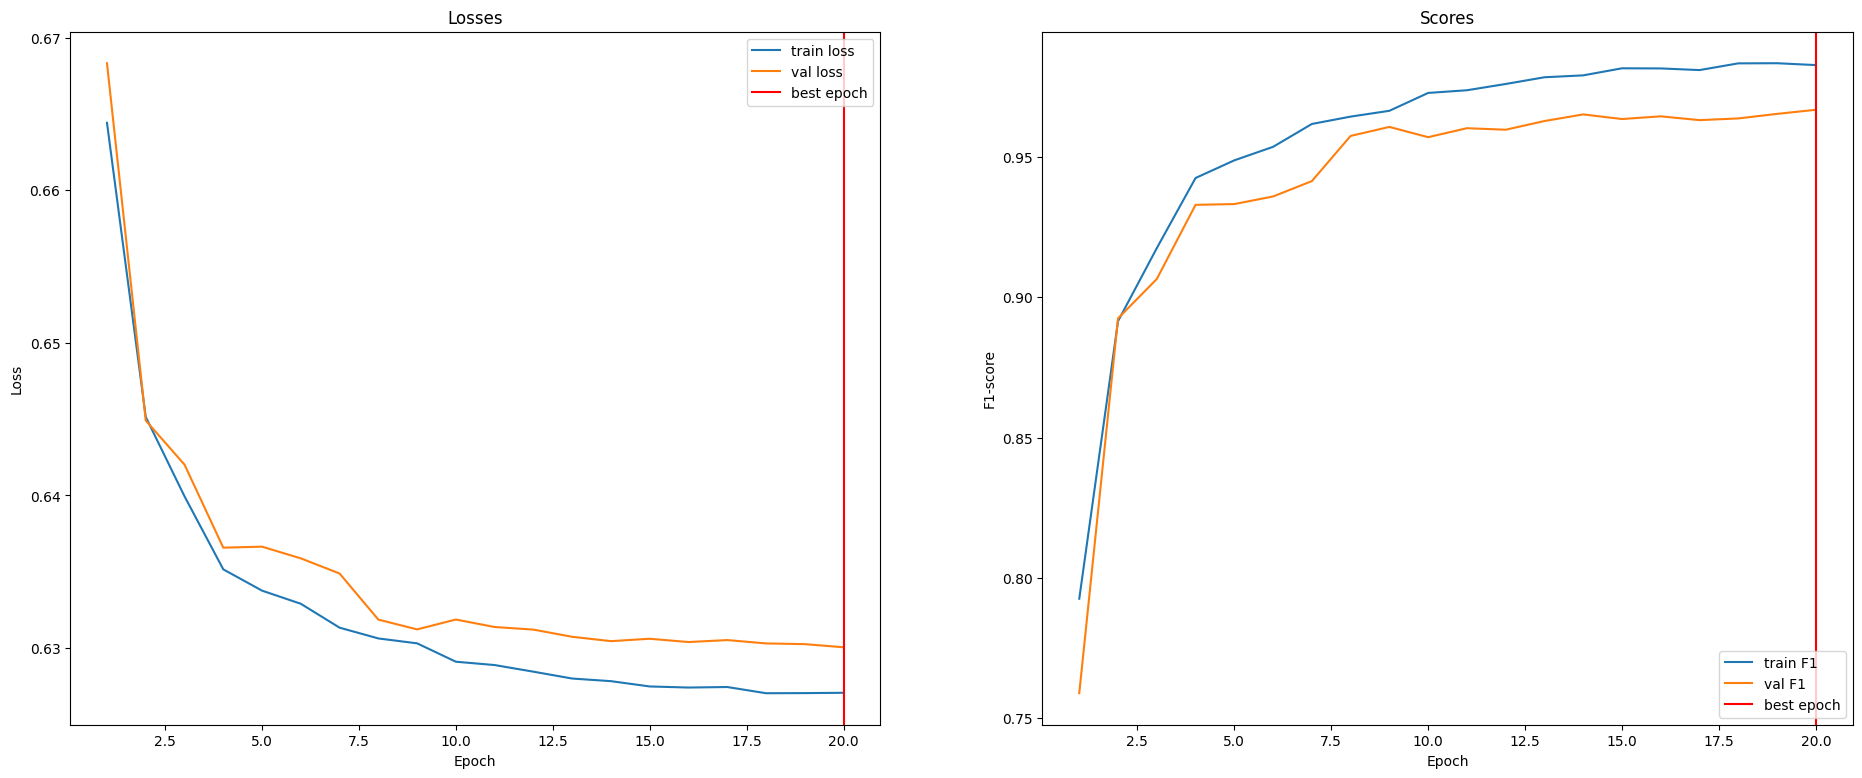

<Artifact model>

In [ ]:
seed_torch(seed)
best_model_weights, train_losses, val_losses, train_full_f1, val_full_f1 = train(
    model, train_loader, val_loader, optimizer, scheduler, config.EPOCHS, config
)

artifact = wandb.Artifact('model', type='model')
artifact.add_file('best_model.pth')
wandb.log_artifact(artifact)

# 3. $SHapley~Additive~exPlanations$.

In [ ]:
import shap

In [ ]:
run = wandb.init()
artifact = run.use_artifact('vlad-gad/apparel_classification/model:v0', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model:v0, 112.68MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.7


In [ ]:
model.load_state_dict(torch.load('/content/artifacts/model:v0/best_model.pth'))

<All keys matched successfully>

In [ ]:
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

# поменять мб трансформы
transform = [
    torchvision.transforms.Resize(config.IMG_SIZE),
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [ ]:
def predict(img):
    image = nhwc_to_nchw(torch.tensor(img))
    model.eval()
    with torch.no_grad():
        target_image_pred = model(image.to(DEVICE))

    return target_image_pred

In [ ]:
for image, targets, labels, col, art in val_loader:
    ground_truth = [label.replace('_', ' ') for label in labels]
    break

In [ ]:
class_names = []
for i in range(len(config.COLOUR_LABELS)):
    for j in range(len(config.ARTICLE_LABELS)):
        class_names.append(config.COLOUR_LABELS[i] + ' ' + config.ARTICLE_LABELS[j])

In [ ]:
a = 0
b = 5
topk = 5
n_evals = 1000
images = torch.zeros((config.BATCH_SIZE, val_dataset[0][0].size(1), val_dataset[0][0].size(2), val_dataset[0][0].size(0)))

for i in range(config.BATCH_SIZE):
    img = Image.open(val_images[i])
    image = transform(torch.tensor(np.array(img)).permute(2, 0, 1)).unsqueeze(0)
    images[i, :, :, :] = image

masker_blur = shap.maskers.Image("blur(128,128)", images[0, :, :, :].shape)
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

shap_values = explainer(
    images[a:b],
    max_evals=n_evals,
    batch_size=config.BATCH_SIZE,
    outputs=shap.Explanation.argsort.flip[:topk],
)

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
PartitionExplainer explainer: 6it [00:18,  6.31s/it]


In [ ]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([5, 128, 128, 3]), (5, 128, 128, 3, 5))

In [ ]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

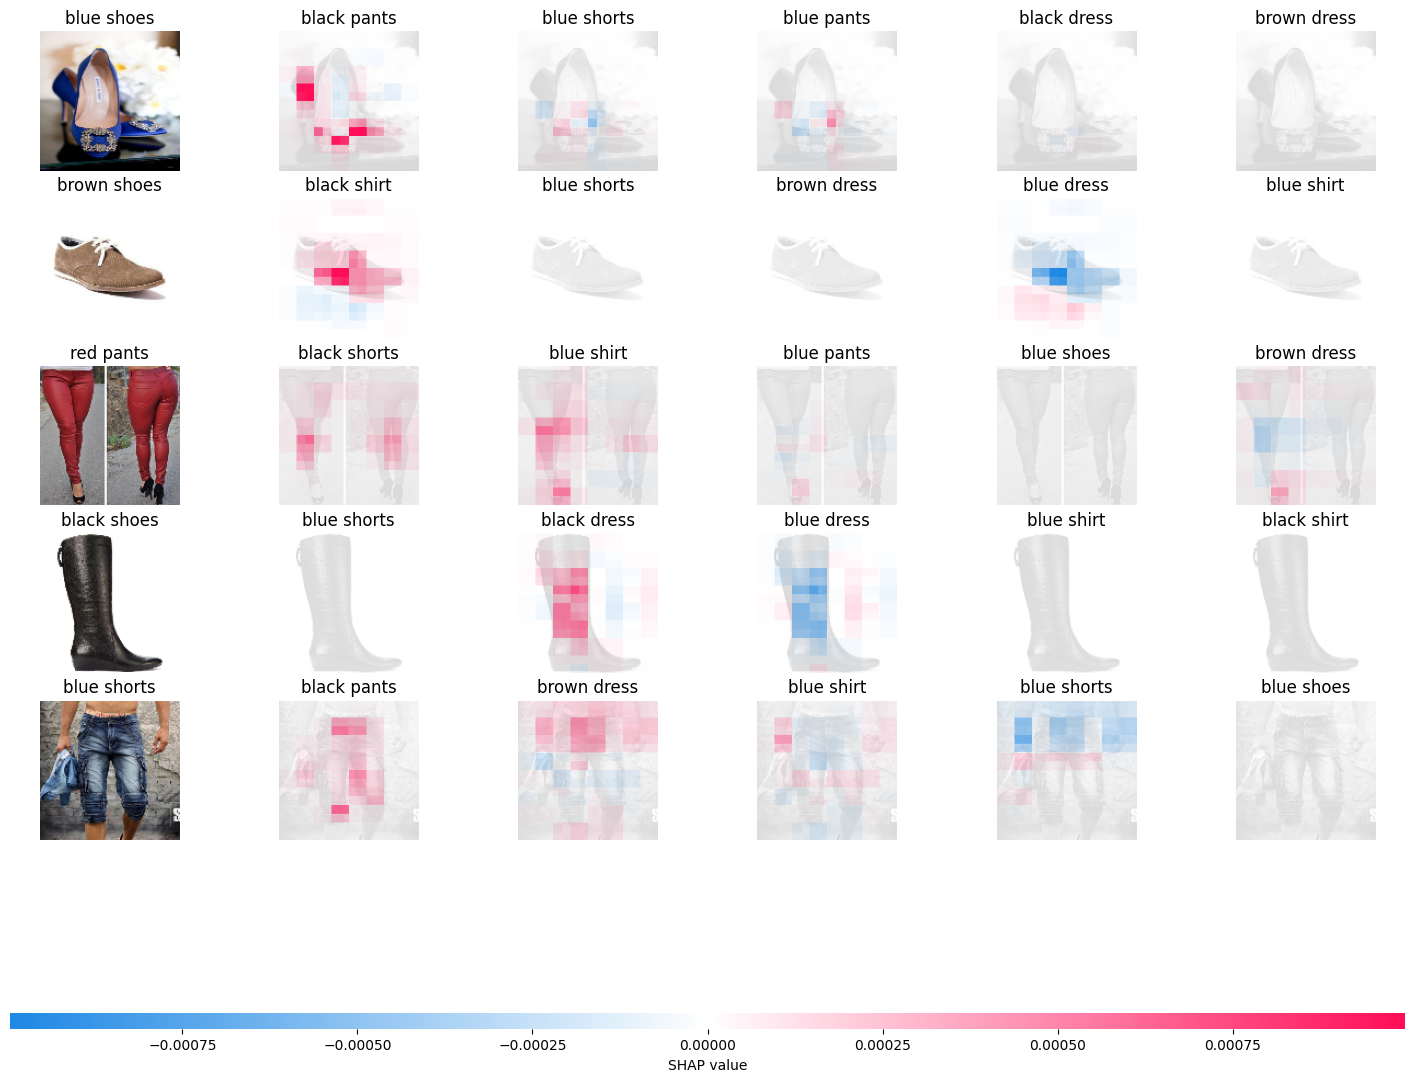

In [ ]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=ground_truth[a:b],
)

Подписи для всех изображений, кроме оригинальных неправильные.

In [ ]:
def predict_label(img):
    image = nhwc_to_nchw(torch.tensor(img))
    model.eval()
    with torch.no_grad():
        target_image_pred = model(image.to(DEVICE))

    col = torch.argmax(target_image_pred[:, :config.N_COLOUR_LABELS], dim=1)
    art = torch.argmax(target_image_pred[:, config.N_COLOUR_LABELS:], dim=1)
    preds = []

    for i in range(col.shape[0]):
        predicted_color = config.COLOUR_LABELS[col[i]]
        predicted_article = config.ARTICLE_LABELS[art[i]]
        target_image_pred_label = predicted_color + ' ' +  predicted_article
        preds.append(target_image_pred_label)

    return preds

Посмотрим на предсказания модели и истинные метки.

In [ ]:
predict_label(images[a:b]), ground_truth[a:b]

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(['blue shoes', 'brown shoes', 'red pants', 'black shoes', 'blue shorts'],
 ['blue shoes', 'brown shoes', 'red pants', 'black shoes', 'blue shorts'])

In [ ]:
def predict_label(img):
    image = nhwc_to_nchw(torch.tensor(img))
    model.eval()
    with torch.no_grad():
        target_image_pred = model(image.to(DEVICE))

    col = torch.argsort(target_image_pred[:, :config.N_COLOUR_LABELS], dim=1, descending=True)
    art = torch.argsort(target_image_pred[:, config.N_COLOUR_LABELS:], dim=1, descending=True)
    preds = []

    for i in range(col.shape[0]):
        predicted_color = [config.COLOUR_LABELS[col[i, j]] for j in range(col.shape[1])]
        predicted_article = [config.ARTICLE_LABELS[art[i, j]] for j in range(art.shape[1])]
        pred = []
        for j in range(col.shape[1]):
            for k in range(art.shape[1]):
                if j == k:
                    target_image_pred_label = predicted_color[j] + ' ' +  predicted_article[k]
                    preds.append(target_image_pred_label)


        #preds.append(pred)

    return preds

Проверим, как ранжируются предсказания модели.

In [ ]:
predict_label(images[0:5]), ground_truth[0:5]

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


([['blue shoes', 'black dress', 'red shorts', 'green shirt', 'brown pants'],
  ['brown shoes', 'white shorts', 'blue pants', 'red dress', 'black shirt'],
  ['red pants', 'white dress', 'green shirt', 'blue shorts', 'black shoes'],
  ['black shoes', 'white pants', 'brown shirt', 'green dress', 'red shorts'],
  ['blue shorts', 'brown pants', 'green shoes', 'black shirt', 'white dress']],
 ['blue shoes', 'brown shoes', 'red pants', 'black shoes', 'blue shorts'])

Как можно видеть подписи над картами значений $SHAP$ не соответствуют тем, которые предсказываются моделью. Попробуем исправить.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


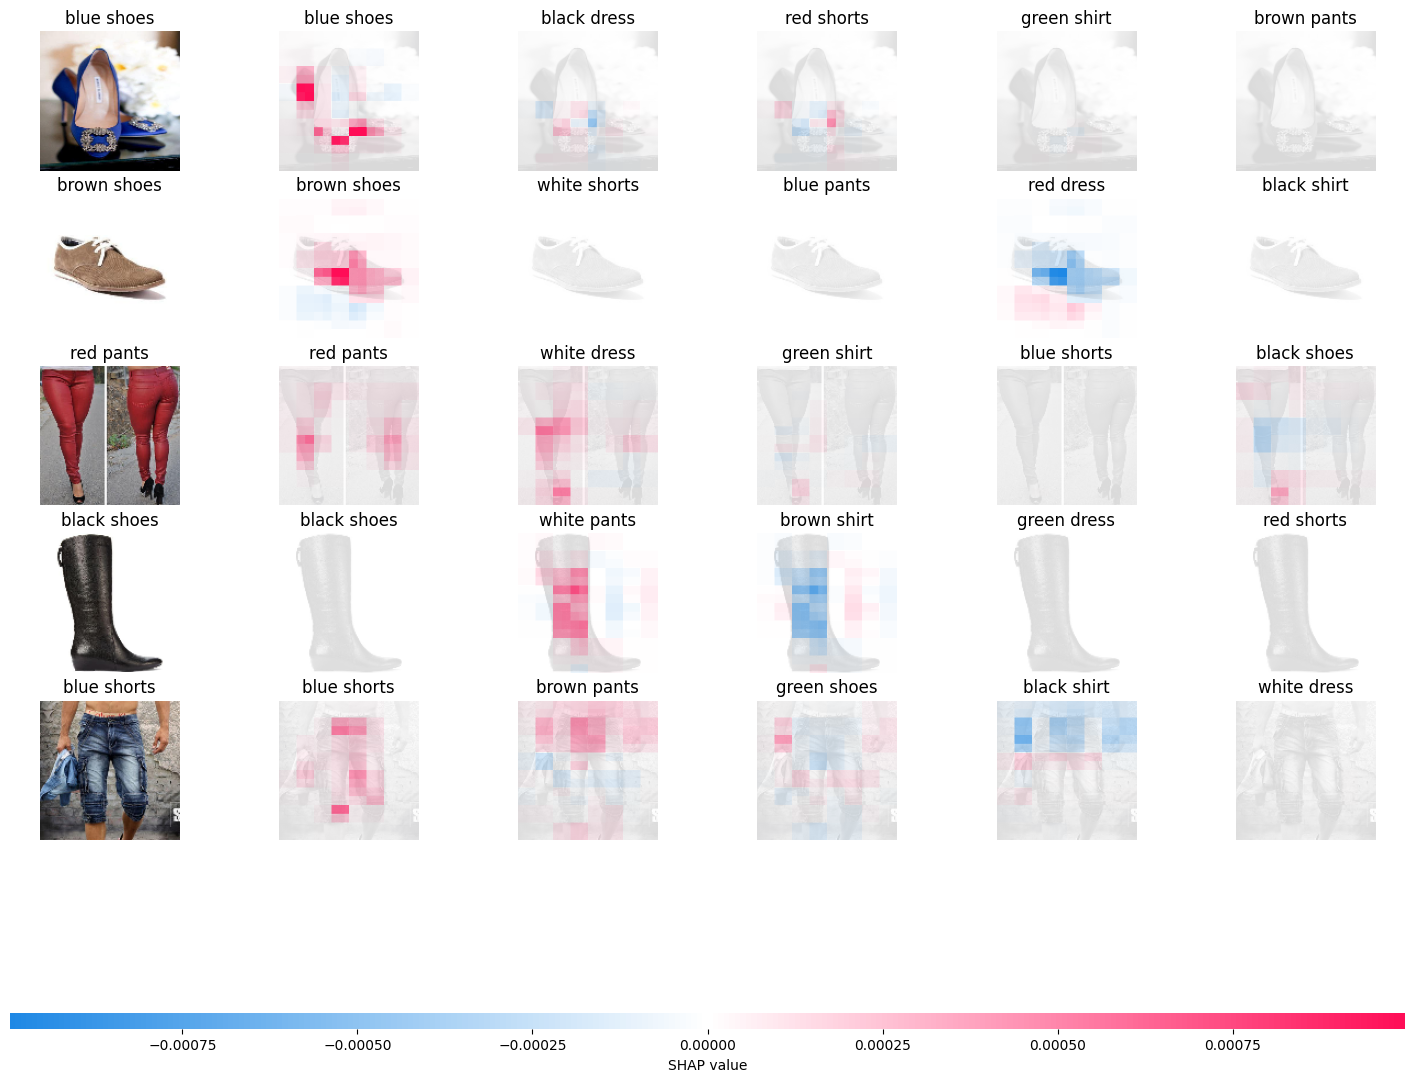

In [ ]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=np.array(predict_label(images[a:b])).reshape(5, 5),
    true_labels=ground_truth[a:b],
    show=False
)

buffer = BytesIO()
plt.savefig(buffer, format='jpg')
buffer.seek(0)
shap_img = buffer.getvalue()
buffer.close()
img_bytes = BytesIO(shap_img)
pil_img = Image.open(img_bytes)
wandb.log({'shap_img': [wandb.Image(pil_img, caption='shap_img')]})

 Но, если абстрагироваться от неправильных подписей изображений и опираться на предсказания модели, которые выведены выше, то:


1.   Для первого изображения основные признаки, позволяющие правильно определить цвет и предмет одежды, имеют относительно высокие положительные значения $SHAP$.
2.   Для второго изображения аналогично.
3.   Для третьего изображения высокие положительные значения значений $SHAP$ образуют форму штанов.
4.   Для четвёртого изображения всё сложнее гораздо, поскольку значения $SHAP$ нулевые.
5.   Пятое изображение аналогично третьему.

Кажется, что предмет одежды определяет форму, которую будут очерчивать высокие значения $SHAP$, а правильный цвет характеризуется положительными значениями $SHAP$.




